### Importing libraries

In [36]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
from tensorflow.keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping 
from sklearn.model_selection import train_test_split 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers
from keras.models import *
from keras.layers import *
import keras
import warnings
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications.vgg19 import VGG19
warnings.filterwarnings('ignore')

### prétraitement 

In [37]:
def data_prep(malaria,normal):

    malaria = ["./dataset/Malaria" + '/' +  m for m in malaria]
    normal  = ["./dataset/Normal" + '/' +  n for n  in normal]

    labels = len(malaria)*['malaria'] + len(normal)*['normal']
    data = malaria + normal
    return pd.DataFrame({'Image_Path': data , 'Labels': labels})

df = data_prep(os.listdir('./dataset/Malaria/'), os.listdir('./dataset/Normal/'))
df.head()

,Image_Path,Labels
0,./dataset/Malaria/C100P61ThinF_IMG_20150918_14...,malaria
1,./dataset/Malaria/C100P61ThinF_IMG_20150918_14...,malaria
2,./dataset/Malaria/C100P61ThinF_IMG_20150918_14...,malaria
3,./dataset/Malaria/C100P61ThinF_IMG_20150918_14...,malaria
4,./dataset/Malaria/C100P61ThinF_IMG_20150918_14...,malaria


Displaying 5 Malaria cell Images: 



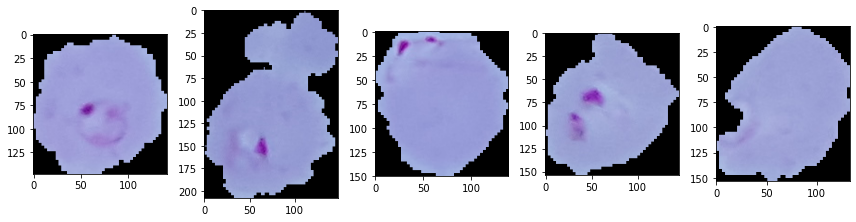


Displaying 5 Normal cell Images: 



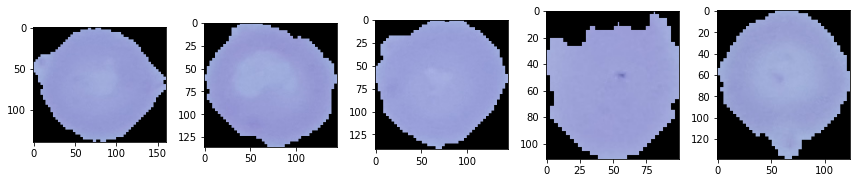

In [38]:

print("Displaying 5 Malaria cell Images: ")
print()
plt.figure(figsize = (12,12))
for i in range(5):
    plt.subplot(1, 5, i+1)
    img = cv2.imread(df[df['Labels'] == 'malaria']['Image_Path'][i])
    plt.imshow(img)
    plt.tight_layout()
plt.show()


print()
print("Displaying 5 Normal cell Images: ")
print()
plt.figure(figsize = (12,12))
for i in range(5):
    plt.subplot(1, 5, i+1)
    img = cv2.imread(df[df['Labels'] == 'normal']['Image_Path'].reset_index(drop=True)[i])
    plt.imshow(img)
    plt.tight_layout()
plt.show()

### Augmentation des données 

In [46]:
train, test = train_test_split(df, test_size = .20)

img_datagen = ImageDataGenerator(rotation_range=20,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              shear_range=0.1,
                              zoom_range=0.1,
                              horizontal_flip=True,
                              fill_mode='nearest', validation_split=0.2)
                               
                               
my_callbacks = [
   
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),]

In [1]:
def plot_loss_and_accuracy(mo_fit):
    accuracy = mo_fit.history['accuracy']
    loss = mo_fit.history['loss']
    validation_loss = mo_fit.history['val_loss']
    validation_accuracy = mo_fit.history['val_accuracy']

    plt.figure(figsize=(15, 7))
    plt.subplot(2, 2, 1)
    plt.plot(range(len(accuracy)), accuracy, label='Training Accuracy')
    plt.plot(range(len(accuracy)), validation_accuracy, label='Validation Accuracy')
    plt.legend(loc='upper left')
    plt.title('Accuracy : Training Vs Validation ')



    plt.subplot(2, 2, 2)
    plt.plot(range(len(accuracy)), loss, label='Training Loss')
    plt.plot(range(len(accuracy)), validation_loss, label='Validation Loss')
    plt.title('Loss : Training Vs Validation ')
    plt.legend(loc='upper right')
    plt.show()

### CNN Model (version 1 )

In [48]:
def cnn_model(df, train, test, my_callbacks):
    
    x_train =  img_datagen.flow_from_dataframe(dataframe = train,  x_col='Image_Path', y_col='Labels',  class_mode='binary',target_size=(134,134), shuffle=False, batch_size=10, seed=10, subset='training')
    x_test = img_datagen.flow_from_dataframe(dataframe = test,  x_col='Image_Path', y_col='Labels',class_mode='binary',  target_size=(134,134), shuffle=False, batch_size=10, seed=10, subset='validation')
    
    model = tf.keras.Sequential(
        [
          tf.keras.layers.Conv2D(kernel_size=(3,3), input_shape=(130,130,3) ,filters=32, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Conv2D(kernel_size=(3,3), input_shape=(130,130,3) ,filters=32, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Conv2D(kernel_size=(3,3), input_shape=(130,130,3) ,filters=32, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Conv2D(kernel_size=(3,3), input_shape=(130,130,3) ,filters=64, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(128, activation='relu'),
          tf.keras.layers.Dropout(rate=0.5),
          tf.keras.layers.Dense(1, activation='sigmoid')
  ])
    model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

    model_history = model.fit_generator(generator = x_train, 
                   steps_per_epoch = 100,
                   epochs = 4 ,
                   validation_data = x_test,
                   validation_steps = 100, callbacks=my_callbacks)
    
    return model_history


### Testing CNN model 

Found 17637 validated image filenames belonging to 2 classes.
Found 1102 validated image filenames belonging to 2 classes.
Epoch 1/4
100/100 [==============================] - 19s 186ms/step - loss: 2.4947 - accuracy: 0.5410 - val_loss: 0.6740 - val_accuracy: 0.5760
Epoch 2/4
100/100 [==============================] - 18s 176ms/step - loss: 0.6815 - accuracy: 0.5650 - val_loss: 0.6894 - val_accuracy: 0.5350
Epoch 3/4
100/100 [==============================] - 17s 166ms/step - loss: 0.6911 - accuracy: 0.5480 - val_loss: 0.6856 - val_accuracy: 0.5520
Epoch 4/4
100/100 [==============================] - 16s 162ms/step - loss: 0.6907 - accuracy: 0.5380 - val_loss: 0.6647 - val_accuracy: 0.5910


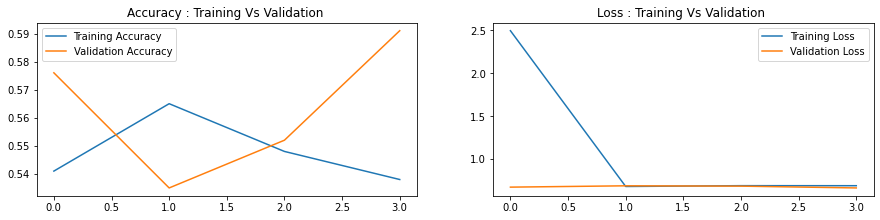

In [49]:
plot_loss_and_accuracy(cnn_model(df, train, test, my_callbacks))


### VGG 19 Model 

In [50]:
def vgg19_model(df, train, test, my_callbacks):
    x_train =  img_datagen.flow_from_dataframe(dataframe = train,  x_col='Image_Path', y_col='Labels',  class_mode='binary',target_size=(224,224), shuffle=False, batch_size=10, seed=10, subset='training')
    x_test = img_datagen.flow_from_dataframe(dataframe = test,  x_col='Image_Path', y_col='Labels',class_mode='binary',  target_size=(224,224), shuffle=False, batch_size=10, seed=10, subset='validation')
    
    vgg19_model = VGG19(input_shape=(224,224,3), weights='imagenet',include_top=False)
    model=Sequential()
    model.add(vgg19_model)
    model.add(Flatten())
    model.add(Dense(1024,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer=keras.optimizers.RMSprop(lr=1e-4),loss='binary_crossentropy',metrics=['accuracy'])
    
    model_history = model.fit(
    x_train,
    steps_per_epoch=100,
    validation_data=x_test,
    validation_steps=100, 
    epochs = 4 , callbacks=my_callbacks)
    
    return model_history

### Testing vgg 19 model 

Found 17637 validated image filenames belonging to 2 classes.
Found 1102 validated image filenames belonging to 2 classes.
Epoch 1/4
100/100 [==============================] - 843s 8s/step - loss: 1.3773 - accuracy: 0.5080 - val_loss: 0.6550 - val_accuracy: 0.7270
Epoch 2/4
100/100 [==============================] - 866s 9s/step - loss: 0.4671 - accuracy: 0.7760 - val_loss: 1.3416 - val_accuracy: 0.9080
Epoch 3/4
100/100 [==============================] - 844s 8s/step - loss: 0.2793 - accuracy: 0.9290 - val_loss: 0.3212 - val_accuracy: 0.9420
Epoch 4/4
100/100 [==============================] - 845s 8s/step - loss: 0.2396 - accuracy: 0.9340 - val_loss: 0.1657 - val_accuracy: 0.9530


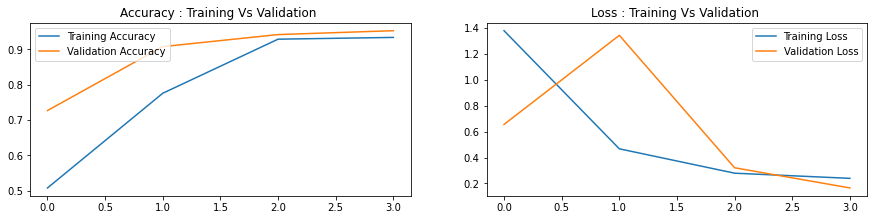

In [51]:
plot_loss_and_accuracy(vgg19_model(df, train, test, my_callbacks))


### Enhancing the CNN Model 

### prétraitement des images

In [54]:
img_dir = "./dataset/"
IMAGE_SIZE = 64
BATCH_SIZE = 32
train_ds = keras.preprocessing.image_dataset_from_directory(img_dir,
                                               
                                                seed=42,
                                                validation_split=0.2,
                                                subset="training",
                                                image_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                batch_size=BATCH_SIZE)

val_ds = keras.preprocessing.image_dataset_from_directory(img_dir,
                                        
                                                seed=42,
                                                validation_split=0.2,
                                                subset="validation",
                                                image_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                batch_size=BATCH_SIZE)

Found 27558 files belonging to 2 classes.
Using 22047 files for training.
Found 27558 files belonging to 2 classes.
Using 5511 files for validation.


### Construction d'un model cnn

In [55]:
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
inp = keras.layers.Input(shape=INPUT_SHAPE)
data_aug = keras.layers.experimental.preprocessing.Rescaling(1./255)(inp)
conv1 = Conv2D(32, kernel_size=3, activation="relu", padding="same")(data_aug)
pool1 = MaxPooling2D(2)(conv1)
norm1 = BatchNormalization(axis= -1)(pool1)
drop1 = Dropout(0.2)(norm1)

conv2 = Conv2D(32, kernel_size=3, activation="relu",
              padding="same")(drop1)
pool2 = MaxPooling2D(2)(conv2)
norm2 = BatchNormalization(axis= -1)(pool2)
drop2 = Dropout(0.2)(norm2)

flat = Flatten()(drop2)

hidden1 = Dense(512, activation="relu")(flat)
norm3 = BatchNormalization(axis= -1)(hidden1)
drop3 = Dropout(0.2)(norm3)

hidden2 = Dense(512, activation="relu")(drop3)
norm4 = BatchNormalization(axis= -1)(hidden2)
drop4 = Dropout(0.2)(norm4)

out = Dense(2, activation="sigmoid")(drop4)

model2 = keras.Model(inputs=inp, outputs=out)
model2.compile(optimizer="adam",
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])
print(model2.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
dropout_7 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 32, 32, 32)       

### Model de cnn version 2 acc = 95%

In [56]:
history1 = model2.fit(train_ds,
                   epochs=10,
                   steps_per_epoch=len(train_ds),
                   validation_data=val_ds,
                   validation_steps=len(val_ds))

Epoch 1/10
689/689 [==============================] - 115s 167ms/step - loss: 0.4547 - accuracy: 0.7861 - val_loss: 0.3878 - val_accuracy: 0.8439
Epoch 2/10
689/689 [==============================] - 111s 161ms/step - loss: 0.2344 - accuracy: 0.9150 - val_loss: 0.1755 - val_accuracy: 0.9437
Epoch 3/10
689/689 [==============================] - 109s 158ms/step - loss: 0.1899 - accuracy: 0.9351 - val_loss: 0.1423 - val_accuracy: 0.9512
Epoch 4/10
689/689 [==============================] - 107s 156ms/step - loss: 0.1597 - accuracy: 0.9454 - val_loss: 0.1592 - val_accuracy: 0.9492
Epoch 5/10
689/689 [==============================] - 111s 161ms/step - loss: 0.1487 - accuracy: 0.9488 - val_loss: 0.1443 - val_accuracy: 0.9494
Epoch 6/10
689/689 [==============================] - 102s 148ms/step - loss: 0.1342 - accuracy: 0.9543 - val_loss: 0.1637 - val_accuracy: 0.9432
Epoch 7/10
689/689 [==============================] - 102s 147ms/step - loss: 0.1251 - accuracy: 0.9558 - val_loss: 0.1347 -